abrimos el json


In [1]:
# Con estas 2 lineas recargamos automaticamente todos los archivos afiliados al proyecto, sin necesidad de usar el boton de Restart
%load_ext autoreload
%autoreload 2

from modules.open_json import open_json
import folium
 
jsons = list(open_json("../json/mypimes.json"))
geojson = open_json("../json/lha.geojson")
canasta_basica = open_json("../json/canasta_basica.json")
revolico = open_json("../json/revolico.json ")

provincia_map = folium.Map(location=(23.133865,-82.3585654))

for i in range(len(jsons)):
        
    folium.Marker(
        location=[jsons[i]["ubicacion"]["lat"], jsons[i]["ubicacion"]["long"]],
        tooltip=f"{jsons[i]["nombre"]}",
        popup= f"<h1>Municipio: {jsons[i]["municipio"]}✅  Horario: {jsons[i]["horario"]} ⏰</h1>",
        icon=folium.Icon(icon="shopping-cart", color="blue")
    ).add_to(provincia_map)
    
folium.GeoJson(geojson,
               style_function= lambda x: {
                   "fillColor": "#93FF69",
                   "color": "#08CB00"
               }
               ).add_to(provincia_map)
folium
    
provincia_map

In [2]:

from modules.graphs import porciento
import matplotlib.pyplot as plt

m_productos = []

for productos in jsons:
    m_productos = productos["productos"]
    
r_productos = revolico["productos"]
 
cb_productos = canasta_basica["productos"]

union = m_productos + r_productos



porciento de bebidas nacionalaes e internacionales que mas se comercializan

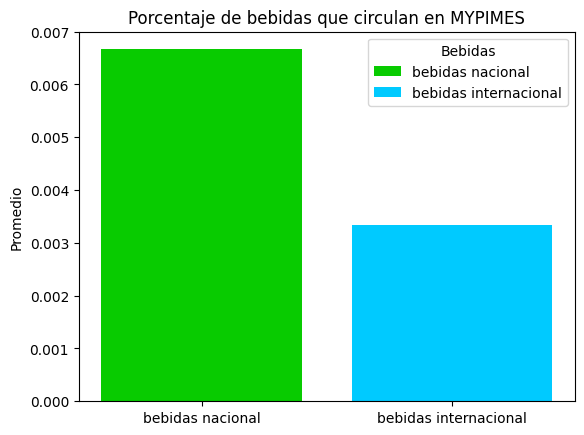

In [3]:
bebida_nacional = []
bebida_internacional = []

for marcas_nacional in m_productos:
    if marcas_nacional["tipo"] == "bebida":
        
        if marcas_nacional["nacional"] == True:
            bebida_nacional.append(marcas_nacional)
            
        if marcas_nacional["nacional"] == False:            
            bebida_internacional.append(marcas_nacional)

porciento_nacional= porciento(total=len(bebida_internacional) + len(bebida_nacional), parte= len(bebida_nacional))/ 100
porciento_internacional = porciento(total=len(bebida_internacional) + len(bebida_nacional), parte= len(bebida_internacional))/ 100


fig , ax = plt.subplots()

ax.bar(["bebidas nacional", "bebidas internacional"],[porciento_internacional, porciento_nacional], label=["bebidas nacional", "bebidas internacional"], color= ["#08CB00", "#00CAFF"])
ax.set_ylabel("Promedio")
ax.legend(title='Bebidas')
ax.set_title("Porcentaje de bebidas que circulan en MYPIMES")
plt.show()      
        

marcas que mas se comercializan

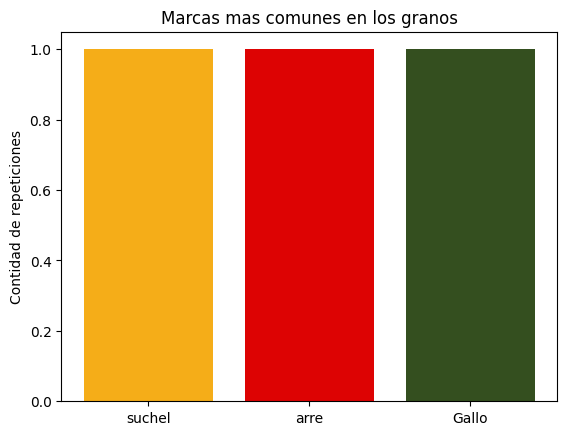

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

marcas_granos = []

for elementos in union:
    if elementos.get("tipo") == "granos":
        marcas_granos.append(elementos.get("marca"))

contador_marcas = Counter(marcas_granos)


lista_valores = list(contador_marcas.values())
lista_valores

fig = plt.bar(list(contador_marcas.keys()), height= lista_valores, color= ["#F5AD18", "#DD0303", "#344F1F"])

plt.title("Marcas mas comunes en los granos")

plt.ylabel("Contidad de repeticiones")
plt.show()


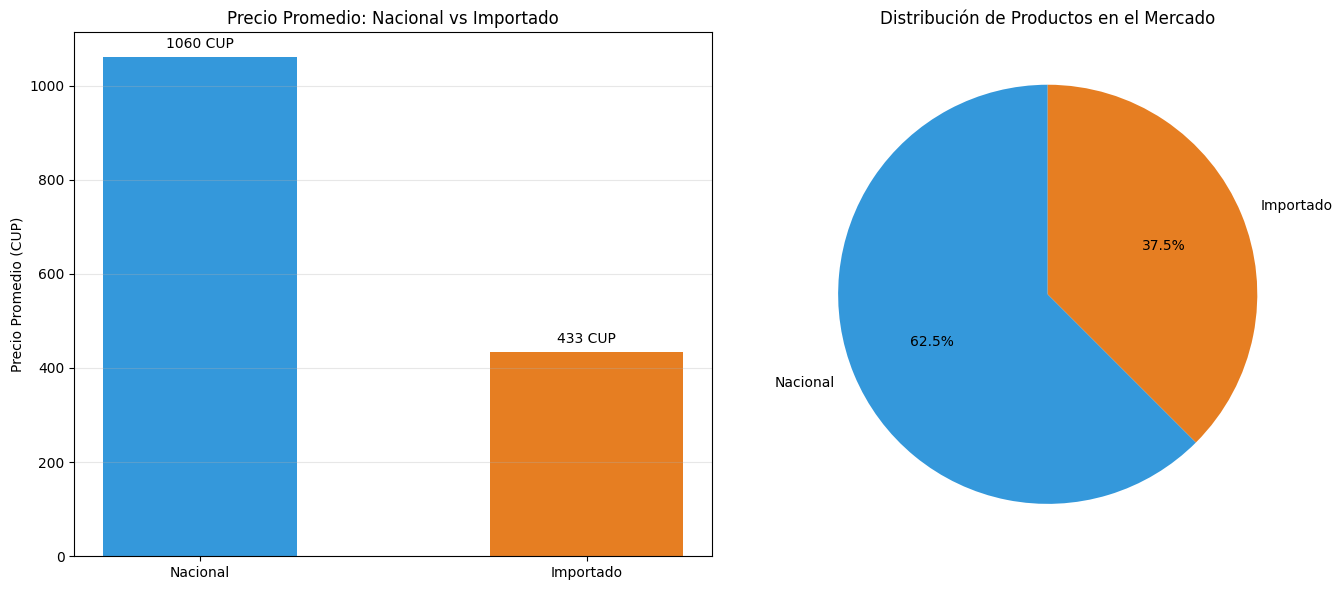

In [5]:
from modules.graphs import promedio
def analizar_nacional_vs_importado():
    
    nacionales = []
    importados = []
    
    for tienda in m_productos:
            if 'nacional' in tienda:
                if tienda['nacional'] == True:
                    nacionales.append(tienda['precio_cup'])
                else:
                    importados.append(tienda['precio_cup'])
    
    promedio_nacional = promedio(nacionales)
    promedio_importado = promedio(importados)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # barras
    categorias = ['Nacional', 'Importado']
    promedios = [promedio_nacional, promedio_importado]
    colores_barras = ['#3498db', '#e67e22']
    
    ax1.bar(categorias, promedios, color=colores_barras, width=0.5)
    ax1.set_ylabel('Precio Promedio (CUP)')
    ax1.set_title('Precio Promedio: Nacional vs Importado')
    ax1.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(promedios):
        ax1.text(i, v + 20, f'{v:.0f} CUP', ha='center')
    
    # pastel
    cantidades = [len(nacionales), len(importados)]
    ax2.pie(cantidades, labels=categorias, autopct='%1.1f%%', colors=colores_barras, startangle=90)
    ax2.set_title('Distribución de Productos en el Mercado')
    
    plt.tight_layout()
    plt.show()

analizar_nacional_vs_importado()

Canasta Básica Mínima: ¿Cuánto cuesta sobrevivir un mes? 

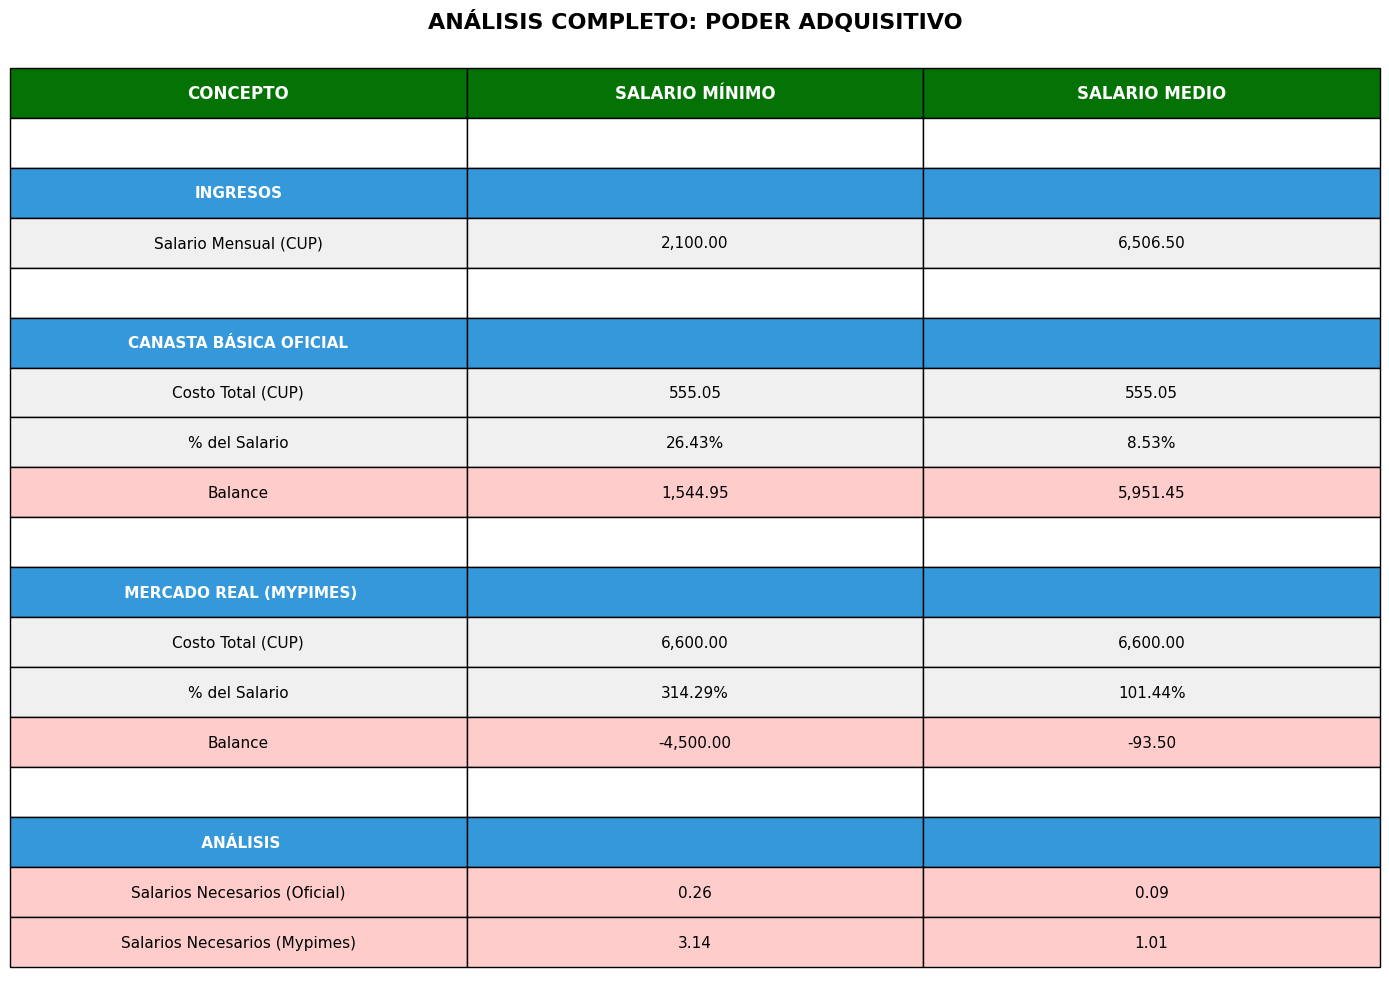

In [ ]:
def tabla_completa_analisis():
    salario_minimo = 2100
    salario_medio = 6506.5
    
    todoscb = []
    todosm = []
    
    for cb in cb_productos:
        precios_cb = cb["precio_cup"]
        todoscb.append(precios_cb)
    suma_cb = sum(todoscb)
    
    for m in m_productos:
        precios_m = m["precio_cup"]
        todosm.append(precios_m)
    suma_m = sum(todosm)
    
    porcentaje_cb_minimo = (suma_cb / salario_minimo) * 100
    porcentaje_cb_medio = (suma_cb / salario_medio) * 100
    porcentaje_m_minimo = (suma_m / salario_minimo) * 100
    porcentaje_m_medio = (suma_m / salario_medio) * 100
    
    balance_cb_minimo = salario_minimo - suma_cb
    balance_cb_medio = salario_medio - suma_cb
    balance_m_minimo = salario_minimo - suma_m
    balance_m_medio = salario_medio - suma_m
    
    
    salarios_nec_cb_minimo = suma_cb / salario_minimo
    salarios_nec_cb_medio = suma_cb / salario_medio
    salarios_nec_m_minimo = suma_m / salario_minimo
    salarios_nec_m_medio = suma_m / salario_medio
    
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('tight')
    ax.axis('off')
    
    datos_tabla = [
        ['CONCEPTO', 'SALARIO MÍNIMO', 'SALARIO MEDIO'],
        ['', '', ''],
        ['INGRESOS', '', ''],
        ['Salario Mensual (CUP)', f'{salario_minimo:,.2f}', f'{salario_medio:,.2f}'],
        ['', '', ''],
        ['CANASTA BÁSICA OFICIAL', '', ''],
        ['Costo Total (CUP)', f'{suma_cb:,.2f}', f'{suma_cb:,.2f}'],
        ['% del Salario', f'{porcentaje_cb_minimo:.2f}%', f'{porcentaje_cb_medio:.2f}%'],
        ['Balance', f'{balance_cb_minimo:,.2f}', f'{balance_cb_medio:,.2f}'],
        ['', '', ''],
        [' MERCADO REAL (MYPIMES)', '', ''],
        ['Costo Total (CUP)', f'{suma_m:,.2f}', f'{suma_m:,.2f}'],
        ['% del Salario', f'{porcentaje_m_minimo:.2f}%', f'{porcentaje_m_medio:.2f}%'],
        ['Balance', f'{balance_m_minimo:,.2f}', f'{balance_m_medio:,.2f}'],
        ['', '', ''],
        [' ANÁLISIS', '', ''],
        ['Salarios Necesarios (Oficial)', f'{salarios_nec_cb_minimo:.2f}', f'{salarios_nec_cb_medio:.2f}'],
        ['Salarios Necesarios (Mypimes)', f'{salarios_nec_m_minimo:.2f}', f'{salarios_nec_m_medio:.2f}']
    ]
    
    colores_filas = []
    for i, fila in enumerate(datos_tabla):
        if i == 0:
            colores_filas.append(['#047204', '#047204', '#047204'])  
        elif i in [2, 5, 10, 15]:
            colores_filas.append(['#3498db', '#3498db', '#3498db'])  
        elif fila[0] == 'Balance' or fila[0].startswith('Salarios Necesarios'):
            colores_filas.append(['#ffcccc', '#ffcccc', '#ffcccc']) 
        elif i in [3, 6, 7, 11, 12, 16, 17]:
            colores_filas.append(['#f0f0f0', '#f0f0f0', '#f0f0f0']) 
        else:
            colores_filas.append(['white', 'white', 'white'])  
    
    tabla = ax.table(cellText=datos_tabla, cellLoc='center', loc='center',
                     cellColours=colores_filas)
    
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1, 2.5)
    
    for i in range(3):
        celda = tabla[(0, i)]
        celda.set_text_props(weight='bold', color='white', size=12)
    
    for idx in [2, 5, 10, 15]:
        for i in range(3):
            celda = tabla[(idx, i)]
            celda.set_text_props(weight='bold', color='white', size=11)
    
    plt.title('ANÁLISIS COMPLETO: PODER ADQUISITIVO', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
tabla_completa_analisis()

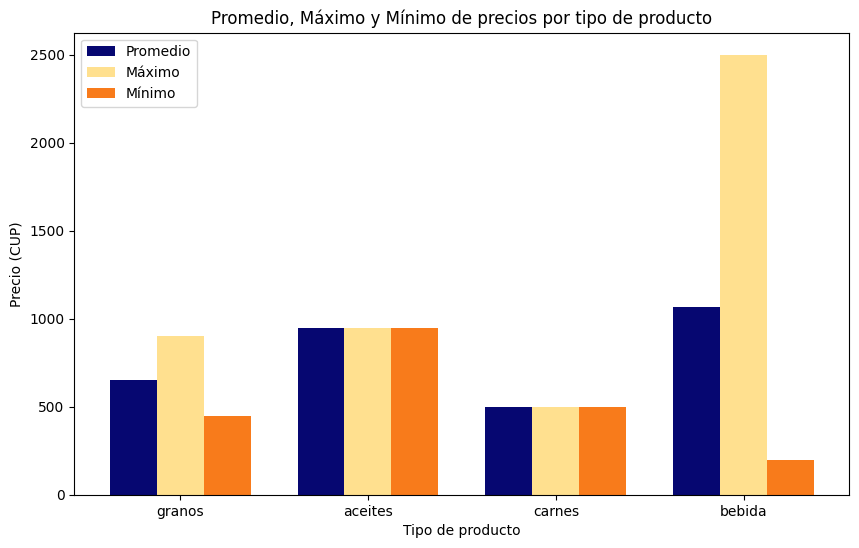

In [7]:
from modules.graphs import pmm
def precios():
    
    tipos_precios = {}
    
    for tienda in m_productos:
        tipo = tienda['tipo']
        precio = tienda['precio_cup']


        if tipo not in tipos_precios:
            tipos_precios[tipo] = []
        tipos_precios[tipo].append(precio)
        
    
    tipos = list(tipos_precios.keys())
    promedios = []
    maximos = []
    minimos = []
    
    for tipo in tipos:
        precios = tipos_precios[tipo]
        promedios.append(sum(precios) / len(precios))
        maximos.append(max(precios))
        minimos.append(min(precios))
    
    pmm(tipos, promedios, maximos, minimos)

precios()

In [8]:
from modules.scraping.eltoque import eltoque_scraper

tasas_cambio = eltoque_scraper()


EUR: 490.0, USD: 445.0, MLC: 265.0


In [9]:
from modules.graphs import presentacion

presentacion(m_productos)

([450], [900], [])

inflacion


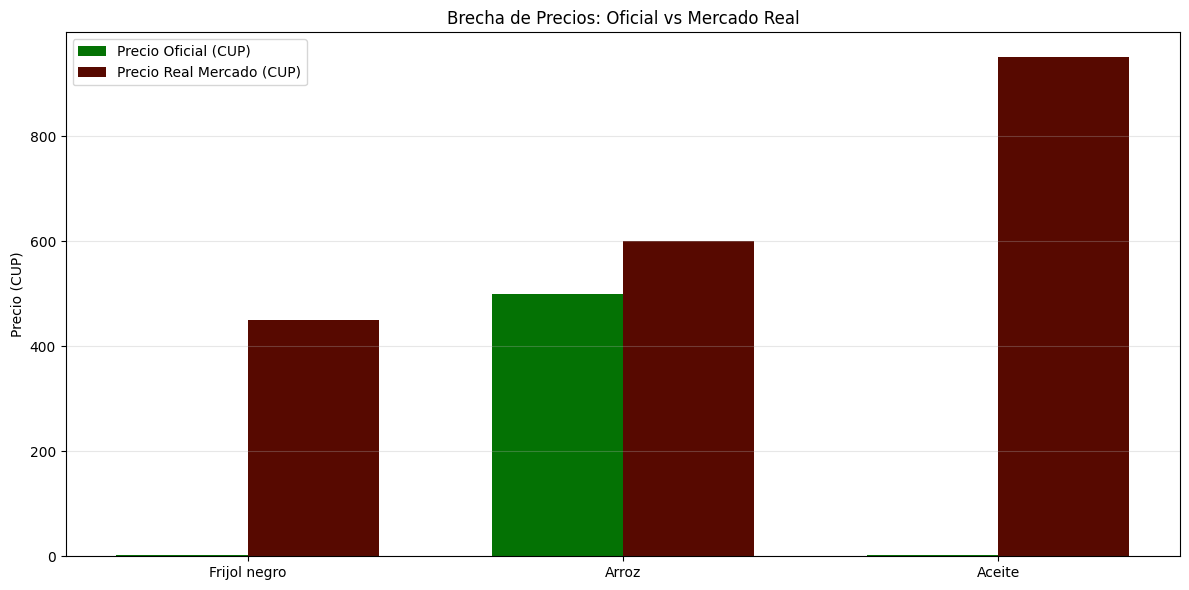

In [10]:
from modules.graphs import calcular_inflacion_real
calcular_inflacion_real(productos_canasta = cb_productos, productos_mypimes = m_productos)


Poder Adquisitivo: ¿Cuántas horas de trabajo se necesitan?

In [ ]:
def horas_trabajo_necesarias(salario_mensual=2100):
    """
    Asumiendo salario mínimo cubano ~2100 CUP/mes
    22 días laborables * 8 horas = 176 horas/mes
    """
    salario_por_hora = salario_mensual / 176
    
    tipos_basicos = ['granos', 'aceites', 'carnes']
    
    productos_basicos = []
    productos_encontrados = {}  
    
    for producto in m_productos:
        if producto['tipo'] in tipos_basicos:
            
            if producto['tipo'] not in productos_encontrados:
                nombre_display = f"{producto['nombre'].title()} ({producto.get('presentacion', 'unidad')})"
                productos_basicos.append((nombre_display, producto['precio_cup']))
                productos_encontrados[producto['tipo']] = True
    
    print(f"Salario por hora: {salario_por_hora:.2f} CUP\n")
    print("Horas de trabajo necesarias para comprar:")
    print("-" * 50)
    
    for producto, precio in productos_basicos:
        horas = precio / salario_por_hora
        print(f"{producto} : {horas:.1f} horas de trabajo")
        print(f"  = {horas/8:.1f} días de trabajo")
        print(f"  = {(precio/salario_mensual)*100:.1f}% del salario mensual")
        print()

horas_trabajo_necesarias()

Salario por hora: 11.93 CUP

Horas de trabajo necesarias para comprar:
--------------------------------------------------
Frijol Negro (lb) : 37.7 horas de trabajo
  = 4.7 días de trabajo
  = 21.4% del salario mensual

Girasol (litros) : 79.6 horas de trabajo
  = 10.0 días de trabajo
  = 45.2% del salario mensual

Pollo (lb) : 41.9 horas de trabajo
  = 5.2 días de trabajo
  = 23.8% del salario mensual

